In [1]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import string
import re
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model
from pandas import DataFrame
from matplotlib import pyplot

[nltk_data] Downloading package stopwords to C:\Users\Mahi's
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def load_doc(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close() 
  return text

In [3]:
# turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

In [5]:
filename = 'D:/dl/content/txt_sentoken/pos/cv000_29590.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print(tokens)

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'theres', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan', 'moore', 'eddie', 'campbell', 'brought', 'medium', 'whole', 'new', 'level', 'mid', 'series', 'called', 'watchmen', 'say', 'moore', 'campbell', 'thoroughly', 'researched', 'subject', 'jack', 'ripper', 'would', 'like', 'saying', 'michael', 'jackson', 'starting', 'look', 'little', 'odd', 'book', 'graphic', 'novel', 'pages', 'long', 'includes', 'nearly', 'consist', 'nothing', 'footnotes', 'words', 'dont', 'dismiss', 'film', 'source', 'get', 'past', 'whole', 'comic', 'book', 'thing', 'might', 'find', 'another', 'stumbling', 'block', 'hells', 'directors', 'albert', 'allen', 'hughes', 'getting', 'hughes', 'brothers', 'direct', 'seems', 'almost', 'ludicrous', 'casting', 'carrot', 'top', 'well', 'anythi

In [6]:
def add_doc_to_vocab(filename, vocab):
  # load doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # update counts
  vocab.update(tokens)

In [7]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  return ' '.join(tokens)

In [8]:
# load all docs in a directory
def process_docs(directory, vocab):
  # walk through all files in the folder
  for filename in listdir(directory):
  # skip any reviews in the test set
    if filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # add doc to vocab
    add_doc_to_vocab(path, vocab)

In [9]:
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('D:/dl/content/txt_sentoken/pos', vocab)
process_docs('D:/dl/content/txt_sentoken/neg', vocab)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


In [10]:
# keep tokens with a min occurrence
min_occurrence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurrence]
print(len(tokens))

25767


In [11]:
# save list to file
# save list to file
def save_list(lines, filename):
  # convert lines to a single blob of text
  data = '\n'.join(lines)
  # open file
  file = open(filename, 'w')
  # write text
  file.write(data)
  # close file
  file.close()
# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

In [12]:
def process_docs(directory, vocab, is_trian):
  lines = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_trian and filename.startswith('cv9'):
      continue
    if not is_trian and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load and clean the doc
    line = doc_to_line(path, vocab)
    # add to list
    lines.append(line)
  return lines

In [13]:
def prepare_data(train_docs, test_docs, mode):
  # create the tokenizer
  tokenizer = Tokenizer()
  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)
  # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
  # encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
  return Xtrain, Xtest

In [14]:
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
  scores = list()
  n_words = Xtest.shape[1]
  # define network
  model = Sequential()
  model.add(Dense(50, input_shape=(n_words,), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  model.fit(Xtrain, ytrain, epochs=50, verbose=2)
  # evaluate
  loss, acc = model.evaluate(Xtest, ytest, verbose=0)
  scores.append(acc)
  print('%d accuracy: %s', acc)
  return scores

In [16]:
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
# load all training reviews
positive_lines = process_docs('D:/dl/content/txt_sentoken/pos', vocab, True)
negative_lines = process_docs('D:/dl/content/txt_sentoken/neg', vocab, True)
train_docs = negative_lines + positive_lines
# load all test reviews
positive_lines = process_docs('D:/dl/content/txt_sentoken/pos', vocab, False)
negative_lines = process_docs('D:/dl/content/txt_sentoken/neg', vocab, False)
test_docs = negative_lines + positive_lines
# prepare labels
ytrain = array([0 for _ in range(900)] + [1 for _ in range(900)])
ytest = array([0 for _ in range(100)] + [1 for _ in range(100)])

In [17]:
save_list(tokens, 'vocab.txt')

Epoch 1/50
57/57 - 6s - loss: 0.4678 - accuracy: 0.7883 - 6s/epoch - 97ms/step
Epoch 2/50
57/57 - 2s - loss: 0.0558 - accuracy: 0.9967 - 2s/epoch - 27ms/step
Epoch 3/50
57/57 - 1s - loss: 0.0159 - accuracy: 1.0000 - 1s/epoch - 26ms/step
Epoch 4/50
57/57 - 2s - loss: 0.0072 - accuracy: 1.0000 - 2s/epoch - 31ms/step
Epoch 5/50
57/57 - 1s - loss: 0.0042 - accuracy: 1.0000 - 1s/epoch - 25ms/step
Epoch 6/50
57/57 - 1s - loss: 0.0028 - accuracy: 1.0000 - 1s/epoch - 23ms/step
Epoch 7/50
57/57 - 1s - loss: 0.0020 - accuracy: 1.0000 - 1s/epoch - 26ms/step
Epoch 8/50
57/57 - 1s - loss: 0.0015 - accuracy: 1.0000 - 1s/epoch - 26ms/step
Epoch 9/50
57/57 - 2s - loss: 0.0011 - accuracy: 1.0000 - 2s/epoch - 27ms/step
Epoch 10/50
57/57 - 2s - loss: 8.7812e-04 - accuracy: 1.0000 - 2s/epoch - 28ms/step
Epoch 11/50
57/57 - 2s - loss: 6.7539e-04 - accuracy: 1.0000 - 2s/epoch - 26ms/step
Epoch 12/50
57/57 - 2s - loss: 5.2107e-04 - accuracy: 1.0000 - 2s/epoch - 33ms/step
Epoch 13/50
57/57 - 1s - loss: 4.0730

57/57 - 2s - loss: 1.5297e-05 - accuracy: 1.0000 - 2s/epoch - 29ms/step
Epoch 50/50
57/57 - 1s - loss: 1.4538e-05 - accuracy: 1.0000 - 1s/epoch - 25ms/step
%d accuracy: %s 0.8949999809265137
Epoch 1/50
57/57 - 6s - loss: 0.4857 - accuracy: 0.7839 - 6s/epoch - 110ms/step
Epoch 2/50
57/57 - 2s - loss: 0.0161 - accuracy: 0.9989 - 2s/epoch - 27ms/step
Epoch 3/50
57/57 - 2s - loss: 0.0043 - accuracy: 1.0000 - 2s/epoch - 27ms/step
Epoch 4/50
57/57 - 1s - loss: 0.0023 - accuracy: 1.0000 - 1s/epoch - 26ms/step
Epoch 5/50
57/57 - 2s - loss: 0.0015 - accuracy: 1.0000 - 2s/epoch - 27ms/step
Epoch 6/50
57/57 - 2s - loss: 0.0010 - accuracy: 1.0000 - 2s/epoch - 27ms/step
Epoch 7/50
57/57 - 2s - loss: 7.2978e-04 - accuracy: 1.0000 - 2s/epoch - 27ms/step
Epoch 8/50
57/57 - 2s - loss: 5.2745e-04 - accuracy: 1.0000 - 2s/epoch - 29ms/step
Epoch 9/50
57/57 - 1s - loss: 3.9798e-04 - accuracy: 1.0000 - 1s/epoch - 26ms/step
Epoch 10/50
57/57 - 1s - loss: 3.0749e-04 - accuracy: 1.0000 - 1s/epoch - 26ms/step
E

Epoch 49/50
57/57 - 1s - loss: 0.0138 - accuracy: 1.0000 - 955ms/epoch - 17ms/step
Epoch 50/50
57/57 - 1s - loss: 0.0130 - accuracy: 1.0000 - 1s/epoch - 20ms/step
%d accuracy: %s 0.9100000262260437
       binary  count  tfidf  freq
count   1.000  1.000  1.000  1.00
mean    0.905  0.895  0.845  0.91
std       NaN    NaN    NaN   NaN
min     0.905  0.895  0.845  0.91
25%     0.905  0.895  0.845  0.91
50%     0.905  0.895  0.845  0.91
75%     0.905  0.895  0.845  0.91
max     0.905  0.895  0.845  0.91


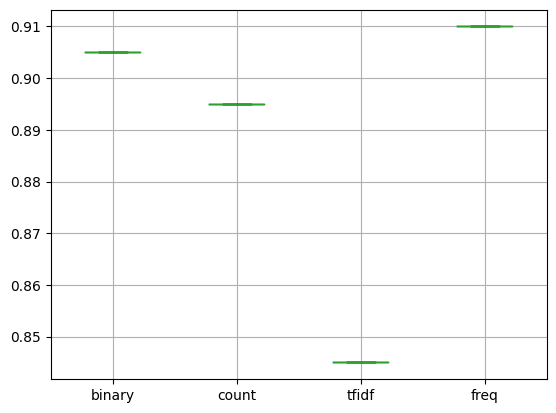

In [18]:
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
  # prepare data for mode
  Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
  # evaluate model on data for mode
  results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
# summarize results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()

In [19]:
def predict_sentiment(review, vocab, tokenizer, model):
  # clean
  tokens = clean_doc(review)
  # filter by vocab
  tokens = [w for w in tokens if w in vocab]
  # convert to line
  line = ' '.join(tokens)
  # encode
  encoded = tokenizer.texts_to_matrix([line], mode='freq')
  # prediction
  yhat = model.predict(encoded, verbose=0)
  return round(yhat[0,0])

In [20]:
# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
tokenizer = create_tokenizer(train_docs)

In [21]:
n_words = Xtest.shape[1]

model = Sequential()
model.add(Dense(50, input_shape=(n_words,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=25, verbose=2)

Epoch 1/25
57/57 - 3s - loss: 0.6924 - accuracy: 0.5328 - 3s/epoch - 46ms/step
Epoch 2/25
57/57 - 1s - loss: 0.6873 - accuracy: 0.6444 - 1s/epoch - 20ms/step
Epoch 3/25
57/57 - 1s - loss: 0.6758 - accuracy: 0.9006 - 1s/epoch - 21ms/step
Epoch 4/25
57/57 - 1s - loss: 0.6575 - accuracy: 0.8417 - 1s/epoch - 22ms/step
Epoch 5/25
57/57 - 1s - loss: 0.6319 - accuracy: 0.9294 - 1s/epoch - 21ms/step
Epoch 6/25
57/57 - 1s - loss: 0.6021 - accuracy: 0.9267 - 1s/epoch - 20ms/step
Epoch 7/25
57/57 - 1s - loss: 0.5685 - accuracy: 0.9406 - 1s/epoch - 21ms/step
Epoch 8/25
57/57 - 1s - loss: 0.5331 - accuracy: 0.9506 - 1s/epoch - 21ms/step
Epoch 9/25
57/57 - 1s - loss: 0.4959 - accuracy: 0.9550 - 1s/epoch - 20ms/step
Epoch 10/25
57/57 - 1s - loss: 0.4604 - accuracy: 0.9561 - 1s/epoch - 20ms/step
Epoch 11/25
57/57 - 1s - loss: 0.4251 - accuracy: 0.9622 - 1s/epoch - 22ms/step
Epoch 12/25
57/57 - 1s - loss: 0.3917 - accuracy: 0.9650 - 1s/epoch - 20ms/step
Epoch 13/25
57/57 - 1s - loss: 0.3609 - accuracy:

In [22]:
text = 'Best movie ever!'
print(predict_sentiment(text, vocab, tokenizer, model))
# test negative text
text = 'This is a bad movie.'
print(predict_sentiment(text, vocab, tokenizer, model))

1
0
